In [1]:
# imports 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os 

porn_df = pd.read_csv('../data/xhamster.csv') # load Sexualitics raw csv
youtube_df = pd.DataFrame() # initialize empty df
for filename in os.listdir('../data/youtube'): 
    if filename != '.DS_Store':
        current_df = pd.read_csv('../data/youtube/%s' %filename)
        youtube_df = pd.concat([youtube_df,current_df], ignore_index=True)

In [2]:
# add porn column and remove extra headings

youtube_df["isPorn"] = pd.Series()
youtube_df=youtube_df.fillna(0)
youTubeTitles = youtube_df.loc[:, ["title", "isPorn"]]


In [3]:
porn_df["isPorn"] = pd.Series()
porn_df=porn_df.fillna(1)
pornTitles = porn_df.loc[:, ["title", "isPorn"]]

In [4]:
#merge datasets
merged_data = youTubeTitles.append(pornTitles, ignore_index=True)
title_matrix= merged_data.loc[:,["title"]]
target_array=merged_data.loc[:, ["isPorn"]]

In [6]:
#folding datasets for training
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle=True)
kf.get_n_splits(merged_data)
print kf

KFold(n_splits=10, random_state=None, shuffle=True)


In [46]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Activation, Dropout

In [8]:
pornarray = pornTitles.values
not_empty = pornTitles.values[:,0] != 1
full_pornarray = pornarray[not_empty]
print len(pornarray)
print len(full_pornarray)
print len(pornarray) - len(full_pornarray)

786121
785329
792


In [91]:
for train_index, test_index in kf.split(title_matrix):
    
    #Folding steps
    start_train= train_index[0]
    end_train=train_index[-1]
    start_test=test_index[0]
    end_test=test_index[-1]
    #print "TRAIN:", train_index, "TEST", test_index
    X_train, X_test = title_matrix.loc[start_train:end_train], title_matrix.loc[start_test:end_test]
    y_train, y_test = target_array.loc[start_train:end_train], target_array.loc[start_test:end_test]
    print y_train
    
    
    # fix random seed for reproducibility
    numpy.random.seed(7)

    # create the model
    total_length=len(X_train) #this needs to be the length of the dictionary we use to encode the titles
    embedding_vecor_length = 32
    model = Sequential()
    model.add(Embedding(total_length, embedding_vecor_length, input_length=None))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    model.fit(X_train, y_train, nb_epoch=3, batch_size=64)

    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    
    #RNN model above


        isPorn
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
5          0.0
6          0.0
7          0.0
8          0.0
9          0.0
10         0.0
11         0.0
12         0.0
13         0.0
14         0.0
15         0.0
16         0.0
17         0.0
18         0.0
19         0.0
20         0.0
21         0.0
22         0.0
23         0.0
24         0.0
25         0.0
26         0.0
27         0.0
28         0.0
29         0.0
...        ...
928594     1.0
928595     1.0
928596     1.0
928597     1.0
928598     1.0
928599     1.0
928600     1.0
928601     1.0
928602     1.0
928603     1.0
928604     1.0
928605     1.0
928606     1.0
928607     1.0
928608     1.0
928609     1.0
928610     1.0
928611     1.0
928612     1.0
928613     1.0
928614     1.0
928615     1.0
928616     1.0
928617     1.0
928618     1.0
928619     1.0
928620     1.0
928621     1.0
928622     1.0
928623     1.0

[928624 rows x 1 columns]
___________________________________________

ValueError: could not convert string to float: jeg leger

In [10]:
import string

vocab = [x for x in string.ascii_lowercase] + [x for x in string.punctuation] + [x for x in string.digits]
vocab.append(' ')
vocab.append('END')
vocab.append('specialchar')
vocab = set(vocab)
#vocab.append(string.punctuation)
#vocab.append(string.digits)
print vocab
print len(vocab)

set(['specialchar', '!', ' ', '#', '"', '%', '$', "'", '&', ')', '(', '+', '*', '-', ',', '/', '.', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8', ';', ':', '=', '<', '?', '>', '@', 'END', '[', ']', '\\', '_', '^', 'a', '`', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'h', 'k', 'j', 'm', 'l', 'o', 'n', 'q', 'p', 's', 'r', 'u', 't', 'w', 'v', 'y', 'x', '{', 'z', '}', '|', '~'])
71


In [11]:
# vocab is 70
# create character index

char_index = dict((c, i) for i, c in enumerate(vocab))
print char_index

{'specialchar': 0, '!': 1, ' ': 2, '#': 3, '"': 4, '%': 5, '$': 6, "'": 7, '&': 8, ')': 9, '(': 10, '+': 11, '*': 12, '-': 13, ',': 14, '/': 15, '.': 16, '1': 17, '0': 18, '3': 19, '2': 20, '5': 21, '4': 22, '7': 23, '6': 24, '9': 25, '8': 26, ';': 27, ':': 28, '=': 29, '<': 30, '?': 31, '>': 32, '@': 33, 'END': 34, '[': 35, ']': 36, '\\': 37, '_': 38, '^': 39, 'a': 40, '`': 41, 'c': 42, 'b': 43, 'e': 44, 'd': 45, 'g': 46, 'f': 47, 'i': 48, 'h': 49, 'k': 50, 'j': 51, 'm': 52, 'l': 53, 'o': 54, 'n': 55, 'q': 56, 'p': 57, 's': 58, 'r': 59, 'u': 60, 't': 61, 'w': 62, 'v': 63, 'y': 64, 'x': 65, '{': 66, 'z': 67, '}': 68, '|': 69, '~': 70}


In [12]:
youTubearray = youTubeTitles.values
youTubearray

array([['Eminem - Walk On Water (Audio) ft. Beyonc\xc3\xa9', 0.0],
       ['PLUSH - Bad Unboxing Fan Mail', 0.0],
       ['Racist Superman | Rudy Mancuso, King Bach & Lele Pons', 0.0],
       ...,
       ['Dancing Furry Ball!', 0.0],
       ['Kacey Musgraves - High Horse (Lyric Video)', 0.0],
       ['First footage of deep-sea anglerfish pair', 0.0]], dtype=object)

In [14]:
# combining youtube and porn titles
titleslist = list(youTubearray[:5000,0]) + list(full_pornarray[:5000,0])
len(titleslist)

10000

In [15]:
maxlength = 0
totallength = 0
count = 0
lengths = []
for title in titleslist:
    currentlength = len(title)
    if currentlength > maxlength:
        maxlength = currentlength
    lengths.append(currentlength)
    totallength += currentlength
    count += 1
print count, totallength, maxlength
avg = totallength/count
print avg

10000 406063 264
40


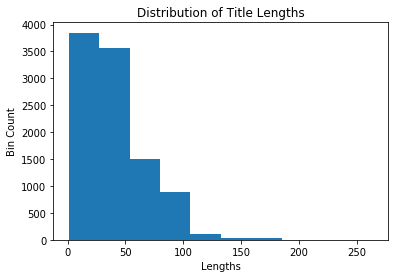

In [16]:
from matplotlib import pyplot as plt

plt.hist(lengths)
plt.title("Distribution of Title Lengths")
plt.xlabel("Lengths")
plt.ylabel("Bin Count")
plt.show()

If we do size 100 majority of titles will be incorporated fully

In [19]:
# one hot encoding
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

#taking firest 5000 porn titles and first 5000 youtube titles to make data more manageable size
encodedlist = []
count = -1
for title in titleslist:
    count += 1
    try:
        int_encoded = [char_index[char] if char in vocab else char_index['specialchar'] for char in title.lower()]
        #make all the title arrays the same size
        if len(title) < 100:
            for i in range(100-len(title)):
                int_encoded.append(char_index["END"])
        onehot_encoded = []
        for value in int_encoded[:100]:
            letter = [0 for _ in range(len(vocab))]
            letter[value] = 1
            onehot_encoded.append(letter)
        encodedlist.append(onehot_encoded)
    except:
        print count, "Problem title:", title
    

In [25]:
len(encodedlist[0])

100

In [86]:
test = [char_index[char] if char in vocab else char_index['specialchar'] for char in titleslist[0].lower()]
for i in range(maxlength-len(title)):
        test.append(char_index["END"])

In [41]:
titleslist[0].lower()

'eminem - walk on water (audio) ft. beyonc\xc3\xa9'

In [65]:
titleslist[12]

'\xe7\x8c\x8e\xe5\x9c\xba | Game Of Hunting 12\xe3\x80\x90TV\xe7\x89\x88\xe3\x80\x91\xef\xbc\x88\xe8\x83\xa1\xe6\xad\x8c\xe3\x80\x81\xe5\xbc\xb5\xe5\x98\x89\xe8\xad\xaf\xe3\x80\x81\xe7\xa5\x96\xe5\xb3\xb0\xe7\xad\x89\xe4\xb8\xbb\xe6\xbc\x94\xef\xbc\x89'

In [52]:
# pull out isPorn values for training data

total_y = list(pornTitles.values[:5000,1])+list(youTubeTitles.values[:5000,1])

In [53]:
# encodedlist is train_X
train_x = encodedlist[:8000]
print np.asarray(train_x).shape

(8000L, 100L, 71L)


In [54]:
train_y = total_y[:8000]
print np.asarray(train_y).shape

(8000L,)


In [56]:
test_x = encodedlist[8000:]
test_y = total_y[8000:]
print np.asarray(test_x).shape
print np.asarray(test_y).shape

(2000L, 100L, 71L)
(2000L,)


In [ ]:
# build model
# https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

#maxlen=100

model = Sequential()
model.add(Embedding(100, 71, input_length = ))
